In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yfin


yfin.pdr_override()
%matplotlib inline

In [3]:
def import_stock_data(tickers, start = '2010-1-1'):
    data = pd.DataFrame()
    if len(tickers) ==1:
        data[tickers[0]] = pdr.get_data_yahoo(tickers[0], start=start)["Adj Close"]
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = pdr.get_data_yahoo(t, start=start)["Adj Close"]
    
    return(data)

In [4]:
data = import_stock_data(['AMD','NVDA','M'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
data.pct_change()

,AMD,NVDA,M
Date,,,
2010-01-04,NaN,NaN,NaN
2010-01-05,0.001031,0.014603,-0.011723
2010-01-06,-0.014418,0.006397,0.014235
2010-01-07,-0.010449,-0.019598,0.022807
2010-01-08,-0.004224,0.002161,-0.032590
...,...,...,...
2023-05-26,0.055505,0.025434,0.021368
2023-05-30,-0.013855,0.029913,-0.016039
2023-05-31,-0.056358,-0.056767,-0.036853


In [6]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [7]:
log_return = log_returns(data)

In [8]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [9]:
drift = drift_calc(data)

In [10]:
stdev = log_returns(data).std().values

In [11]:
def get_tickers(data):
    tickers = [i for i in data.columns]
    return tickers
tickers=get_tickers(data)
tickers

['AMD', 'NVDA', 'M']

In [12]:
def probs_find(predicted, higherthan, ticker = None, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    4. ticker: specific ticker to compute probability for
    """
    if ticker == None:
        if on == 'return':
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")
    else:
        if on == 'return':
            predicted = predicted[predicted['ticker'] == ticker]
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")        
    return (len(over)/(len(over)+len(less)))

In [13]:
def montecarlo_cholesky(tickers, days, iterations, start='2013-1-1', show_hist = False, show_line = False, show_stats=True):
    #Get tickers and number of tickers involved in this portfolio
    data = import_stock_data(tickers, start=start)
    ticks = get_tickers(data)
    numstocks = len(ticks)
    
    #Basic information and data
    log_return = log_returns(data)
    
    #Brownian motion component: drif
    drift = drift_calc(data)
    stdev = log_returns(data).std().values
    
    #Cholesky decomposition
    covari = log_return.cov()
    chol = np.linalg.cholesky(covari)
    
    #Generate uncorralated random variables and use cholesky decomposition to correlate them
    uncorr_x = norm.ppf(np.random.rand(numstocks,iterations*days))
    corr_x = np.dot(chol, uncorr_x)
    
    #Calculate daily return
    corr_2 = np.zeros_like(corr_x)
    for i in range(numstocks):
        corr_2[i] = np.exp(drift[i] + corr_x[i])
    simulatedDF = []    
    #For every stock, calculate the returns
    for s in range(len(ticks)):
        ret_reshape = corr_2[s]
        ret_reshape = ret_reshape.reshape(days,iterations)
        price_list = np.zeros_like(ret_reshape)
        price_list[0] = data.iloc[-1,s]
        #Calculate returns for the s stock
        for t in range(1,days):
            price_list[t] = price_list[t-1]*ret_reshape[t]
        
        #Create dataframe for this run, input the name of stock and load
        y = pd.DataFrame(price_list)   
        y['ticker'] = tickers[s]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        
        #plotting
        if show_hist == True:
            x = pd.DataFrame(price_list).iloc[-1]
            fig, ax = plt.subplots(1,2, figsize=(14,4))
            sns.distplot(x, ax=ax[0],axlabel="Stock Price")
            sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
            plt.xlabel("Stock Price")
            plt.show()
        if show_line == True:
            y = pd.DataFrame(price_list[:,0:10]).plot(figsize=(15,6))
        
        if show_stats == True:
        #Printing basic stats
            print(ticks[s])
            print(f"Days: {days}")
            print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
            print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
            print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
        
    simulatedDF = pd.concat(simulatedDF)
    return(simulatedDF)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


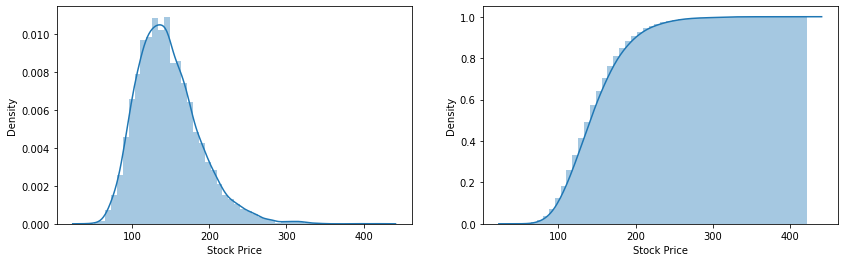

GOOG
Days: 252
Expected Value: $146.46
Return: 14.52%
Probability of Breakeven: 0.6708


C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


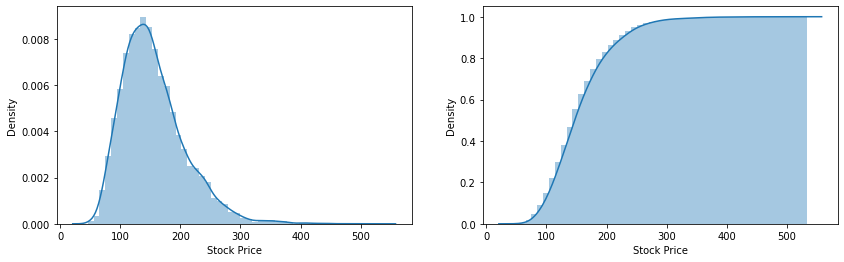

AMZN
Days: 252
Expected Value: $155.2
Return: 19.88%
Probability of Breakeven: 0.694


C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\LAMSD\my_app\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


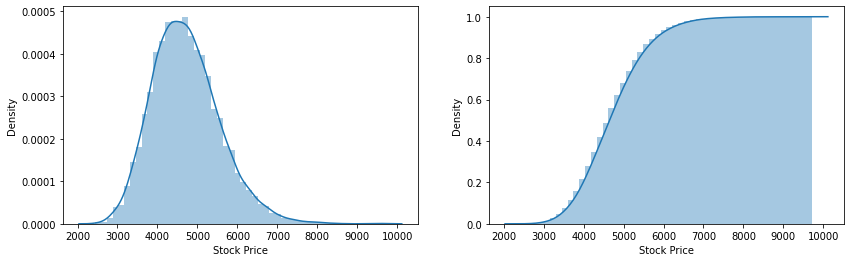

^GSPC
Days: 252
Expected Value: $4716.93
Return: 9.4%
Probability of Breakeven: 0.6781


In [14]:
x = montecarlo_cholesky(['GOOG','AMZN','^GSPC'], days=252, iterations=10000, start='2010-1-1', show_hist=True)

In [15]:
x

,ticker,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,GOOG,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,...,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997,125.199997
1,GOOG,122.979653,126.879401,125.501315,128.433528,121.592256,126.883244,124.609105,122.645311,123.089471,...,125.185318,124.733107,122.045776,128.645302,124.783783,127.080981,126.523602,123.615188,123.716552,123.708630
2,GOOG,126.410849,126.267821,126.810660,126.080264,123.879607,128.797270,125.104261,122.778061,119.114430,...,126.189805,125.027375,121.960081,127.181085,124.008093,130.446605,126.970305,126.254324,124.462092,123.114650
3,GOOG,127.233419,124.023355,125.291692,126.540661,126.559916,126.345418,125.407172,118.656846,121.016071,...,130.468666,125.602397,120.701475,127.897959,124.966058,130.545808,129.910831,129.958608,127.563142,123.453731
4,GOOG,125.350648,119.647056,131.147850,128.882579,128.925488,126.297987,124.610024,116.968410,118.080098,...,131.659538,126.406254,122.149078,129.334818,121.792745,130.814561,128.726223,131.737560,124.286743,126.529722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,^GSPC,4781.319250,3392.553160,7180.699246,3555.158863,4314.792450,5075.678822,5557.246386,4300.513423,4369.550981,...,4592.937644,4348.313868,5363.664501,4477.686398,4386.122334,4039.824551,5292.344838,6311.278647,5898.932048,3874.832521
248,^GSPC,4905.442121,3431.231327,7308.853389,3537.076340,4383.637746,4989.784406,5531.982139,4347.661735,4434.082793,...,4652.129693,4335.460162,5275.839629,4514.757775,4401.249419,4085.861077,5215.412198,6290.212915,5828.368552,3966.232437
249,^GSPC,4700.634705,3459.784417,7359.553652,3517.279475,4362.968173,4981.519444,5545.592847,4279.959102,4493.432999,...,4707.661291,4302.589347,5251.343680,4483.844737,4316.109337,4152.043146,5244.484890,6347.203343,5876.228434,3981.956257
250,^GSPC,4763.547198,3484.992362,7417.872412,3502.690742,4361.719733,4903.641636,5634.923463,4339.156138,4471.522635,...,4680.678463,4381.643885,5287.891071,4478.533545,4367.960080,4194.327146,5187.136375,6465.820901,5899.759522,3988.132237


In [16]:
[col for col in data.columns]

['AMD', 'NVDA', 'M']

## Sharpe Ratio

In [18]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    ticks = [col for col in data.columns]
    if mark_ticker in ticks:
        ann_return = np.exp(log_returns(data).mean()*252).values-1
    else:
        market_data = import_stock_data([mark_ticker], start)
        market_rets = log_returns(market_data).dropna()
        ann_return = np.exp(market_rets.mean()*252).values-1
        data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [26]:
a,b=market_data_combination(data)
a,b

[*********************100%***********************]  1 of 1 completed


(                   AMD        NVDA          M        ^GSPC
 Date                                                      
 2010-01-04    9.700000    4.241589  11.132461  1132.989990
 2010-01-05    9.710000    4.303527  11.001952  1136.520020
 2010-01-06    9.570000    4.331056  11.158563  1137.140015
 2010-01-07    9.470000    4.246176  11.413056  1141.689941
 2010-01-08    9.430000    4.255352  11.041103  1144.979980
 ...                ...         ...        ...          ...
 2023-05-26  127.029999  389.459991  14.340000  4205.450195
 2023-05-30  125.269997  401.109985  14.110000  4205.520020
 2023-05-31  118.209999  378.339996  13.590000  4179.830078
 2023-06-01  119.470001  397.700012  13.750000  4221.020020
 2023-06-02  119.339996  395.494995  15.190000  4276.020020
 
 [3377 rows x 4 columns],
 array([0.10422098]))

In [27]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025, riskpremium = 0.05):
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start) #load data and annual returns
    log_ret = log_returns(dd) # create the logarithmic returns of the data
    covar = log_ret.cov()*252 #Annualized covariance matrix 
    covar = pd.DataFrame(covar.iloc[:-1,-1]) # Get the part of the covariance matrix that is related between the stocks and the market
    mrk_var = log_ret.iloc[:,-1].var()*252 # Annualized variance of market
    beta = covar/mrk_var # Now we have our betas!
    
    #Add the standard deviation to the beta dataframe
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # Get tickers of all the stocks in the dataframe used
    tickers = get_tickers(dd)
    print(mark_ret)
    # Make dictionary for the annual return of each stock
    mark_ret = {tickers[i]:mark_ret[0] for i in range(len(tickers))}
    

    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret[mark_ticker]-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [28]:
beta_sharpe(data)

[*********************100%***********************]  1 of 1 completed
[0.10421848]


,Beta,STD,CAPM,Sharpe
AMD,1.623837,0.560001,0.153638,0.229710
NVDA,1.599869,0.447180,0.151739,0.283419
M,1.269418,0.473884,0.125561,0.212207


In [29]:
data.head()

,AMD,NVDA,M
Date,,,
2010-01-04,9.70,4.241589,11.132461
2010-01-05,9.71,4.303527,11.001952
2010-01-06,9.57,4.331056,11.158563
2010-01-07,9.47,4.246176,11.413056
2010-01-08,9.43,4.255352,11.041103


# Portfolio Optimization

First, we will create a portfolio optimizer that determines the allocation of weights among data that we have - data that is not generated.

Second, we will replicate the same portfolio algorythm, only this time with the average predicted values of all the runs into the future. 

In [30]:
data.head()

,AMD,NVDA,M
Date,,,
2010-01-04,9.70,4.241589,11.132461
2010-01-05,9.71,4.303527,11.001952
2010-01-06,9.57,4.331056,11.158563
2010-01-07,9.47,4.246176,11.413056
2010-01-08,9.43,4.255352,11.041103


In [31]:
log_return = log_returns(data)

weights = np.array(np.random.random(3))
weights = weights/np.sum(weights)

expected_ret = np.sum((log_return.mean()*weights)*252)

expected_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

sharpe = (expected_ret-0.025)/expected_vol

print(f"Weights: {weights}")
print(f"Expected Return of Portfolio: {expected_ret}")
print(f"Expected Volatility: {expected_vol}")
print(f"Sharpe Ratio: {sharpe}")

Weights: [0.59500554 0.19420919 0.21078527]
Expected Return of Portfolio: 0.18210723284169264
Expected Volatility: 0.4250069913560298
Sharpe Ratio: 0.36965799630830865


In [32]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [33]:
import_stock_data(['MSFT','AMZN'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSFT,AMZN
Date,,
2010-01-04,23.572367,6.695000
2010-01-05,23.579977,6.734500
2010-01-06,23.435280,6.612500
2010-01-07,23.191553,6.500000
2010-01-08,23.351501,6.676000
...,...,...
2023-05-25,325.920013,115.000000
2023-05-26,332.890015,120.110001
2023-05-30,331.209991,121.660004


In [34]:
def montecarlo_sharpe_optimal_portfolio(tickers, trials, riskfree=0.025, plot_eff = True, start_date = '2013-1-1', end_date=None):
    if end_date == None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data = import_stock_data(tickers)
    allWeights = np.zeros((trials, len(data.columns)))
    allReturns = np.zeros(trials)
    allVolatility = np.zeros(trials)
    allSharpeValues = np.zeros(trials)
    
    log_return = log_returns(data)
    
    for t in range(trials):
        weights = np.random.rand(len(data.columns))
        weights = weights/np.sum(weights) 
        allWeights[t,:]=weights
        
        allReturns[t] = np.sum((log_return.mean()*weights)*252)
        
        allVolatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
        
        allSharpeValues[t] = (allReturns[t]-riskfree)/allVolatility[t]
    
    maxsharpe = allSharpeValues.max()
    pointsharpe = allSharpeValues.argmax()
    weightSharpe = allWeights[pointsharpe]
    x_sharpe = allVolatility[pointsharpe]
    y_sharpe = allReturns[pointsharpe]
    
    maxret = allReturns.max()
    pointret = allReturns.argmax()
    weightRet = allWeights[pointret]
    x_ret = allVolatility[pointret]
    y_ret = allReturns[pointret]
    
 
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        plt.scatter(allVolatility, allReturns, c=allSharpeValues, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
        plt.scatter(x_sharpe,y_sharpe,c='black')
        plt.scatter(x_ret, y_ret, c='black')
       
    optim_dic = []
    for i in range(len(tickers)):
        optim_dic.append({'ticker':tickers[i],'Weight':weightSharpe[i]})
    print(pd.DataFrame(optim_dic))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
  ticker    Weight
0   MSFT  0.396524
1    UNH  0.603476


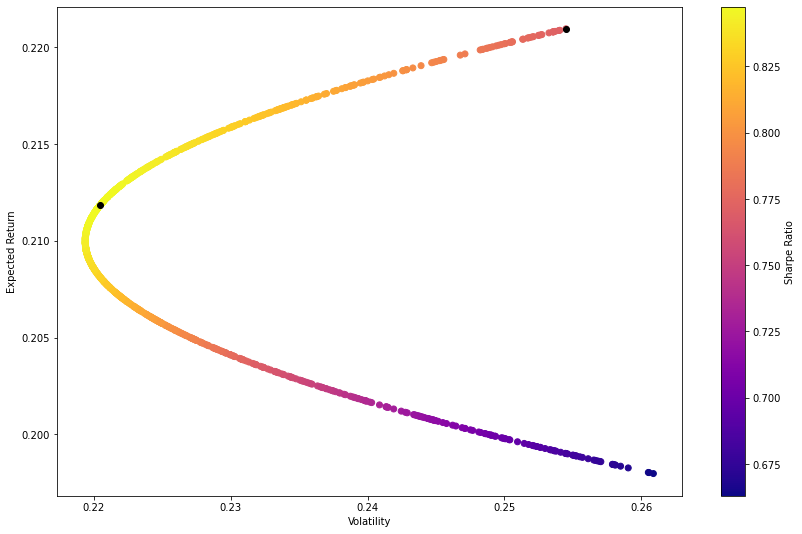

In [35]:
montecarlo_sharpe_optimal_portfolio(['MSFT','UNH'],1000)

In [36]:
import_stock_data(['MSFT','AMZN','APPL'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- APPL: No data found for this date range, symbol may be delisted


,MSFT,AMZN,APPL
Date,,,
2010-01-04,23.572369,6.695000,NaN
2010-01-05,23.579983,6.734500,NaN
2010-01-06,23.435268,6.612500,NaN
2010-01-07,23.191557,6.500000,NaN
2010-01-08,23.351496,6.676000,NaN
...,...,...,...
2023-05-26,332.890015,120.110001,NaN
2023-05-30,331.209991,121.660004,NaN
2023-05-31,328.390015,120.580002,NaN
